In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from Image_Functions import *
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
from IPython.display import HTML
from moviepy.editor import *
import math
from sklearn.externals import joblib
print('import complete')
%matplotlib inline


import complete


In [2]:
#use for tracking data
class heatbox():
    def __init__(self):
        # current unlabeled boxes
        self.current_boxes = []
        # current heat map
        self.current_heat = []
        # previous heat maps
        self.previous_heat = []
        #previous list of all boxes
        self.previous_boxes = [] 
        # boxes to show
        self.show_boxes = []
        #counter
        self.counter = 0
        # centerx, centery, length, width
        self.previous_dimensions = [[(0,0,0,0)]]
        self.current_centers = []
        # List of labeled boxes
        self.current_labeled = [(None,None,None, None)]
        self.previous_labeled = [[(None,None,None, None)]]
        # For tracking false positives
        self.false_positives = 0
        self.num_detected = 0
boxes = heatbox()


In [3]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, hog1, hog2, hog3,spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'     
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(img, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(img, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    return img_features
        

def draw_labeled_bboxes(img, labels, threshold = 1):
    # Iterate through all detected cars
    current_dimensions = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # length and width to store
        box_length = np.max(nonzerox) - np.min(nonzerox)
        box_width = np.max(nonzeroy) - np.min(nonzeroy)
        # length and width to be averaged over multiple frames
        draw_length = box_length
        draw_width = box_width
        # center of box
        centerx = (np.min(nonzerox)+np.max(nonzerox))//2
        centery = (np.min(nonzeroy)+np.max(nonzeroy))//2
        # center to be averaged over multiple frames
        drawx = centerx
        drawy = centery
        #store dimensions in an array
        current_dimensions.append((centerx, centery, box_length, box_width))
        box_count = 1
        # loop through the previous boxes. 
        # Find all boxes in range of heatmap
        # Return the maximum length and width and average center
        for i in range(len(boxes.previous_dimensions)):
            for j in range(len(boxes.previous_dimensions[i])):   
                if (boxes.previous_dimensions[i][j][0] > (centerx -100) and boxes.previous_dimensions[i][j][0] <
                    (centerx + 100) and boxes.previous_dimensions[i][j][1] > (centery -70) and 
                    boxes.previous_dimensions[i][j][1] < (centery +70)):
                    draw_length = max(boxes.previous_dimensions[i][j][2], draw_length)
                    draw_width = max(boxes.previous_dimensions[i][j][3], draw_width)
                    drawx = drawx + boxes.previous_dimensions[i][j][0]
                    drawy = drawy + boxes.previous_dimensions[i][j][1]
                    box_count += 1
        # If the car was found in n out of 3 iterations, draw the box
        if (box_count > threshold):
            # get average center
            drawx = drawx//box_count
            drawy = drawy//box_count
            boxes.num_detected += 1
            # draw the box
            cv2.rectangle(img, (drawx-draw_length//2, drawy-draw_width//2), (drawx+draw_length//2, drawy+draw_width//2), (0,0,255), 6)
        else: 
            # If no boxes found, label as a false positive
            boxes.false_positives += 1
    # store dimensions for later comparison
    
    boxes.previous_dimensions[0] = boxes.previous_dimensions[1]
    boxes.previous_dimensions[1] = boxes.previous_dimensions[2]
    boxes.previous_dimensions[2] = current_dimensions
    return img

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, y_start_stop, x_start_stop, clf, scaler, color_space='BGR', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    t = time.time()
    #Shrink Image
    image_to_search = img[y_start_stop[0]:y_start_stop[1],:,:]
    #Change color space
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_to_search = cv2.cvtColor(image_to_search, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_to_search = cv2.cvtColor(image_to_search, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_to_search = cv2.cvtColor(image_to_search, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_to_search = cv2.cvtColor(image_to_search, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            print('yes')
            ctrans_to_search = cv2.cvtColor(image_to_search, cv2.COLOR_RGB2YCrCb)
    else: 
        ctrans_to_search = np.copy(image_to_search)
    
    dec = y_start_stop[0]
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 3
    ch1 = ctrans_to_search[:,:,0]
    ch2 = ctrans_to_search[:,:,1]
    ch3 = ctrans_to_search[:,:,2]
    
    #get hog features
    if hog_feat==True:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(ctrans_to_search[window[0][1]-dec:window[1][1]-dec, window[0][0]:window[1][0]], (64, 64))
        ypos = (window[0][1]-dec)//pix_per_cell
        xpos = window[0][0]//pix_per_cell
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, hog1, hog2, hog3,
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=False)
        if hog_feat ==True:
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
        features.append(hog_features)
        features = np.concatenate(features)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
   



In [4]:
#parameters - should match parameters in training set

color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

#load training and scaling data
svc = joblib.load('pickle_data.pkl')
X_scaler = joblib.load('scaler.pkl')

In [5]:
def add_heat(heatmap, threshold = 4, num_past = 4):
    # Iterate through list of bboxes
    for box in boxes.current_boxes:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Average heatmaps over the number of last iterations.
    # Don't average in 1st few frames of the video
    if(boxes.counter < num_past+1):
        boxes.counter += 1
    # Add in heat for previous iterations
    for count in range(0, boxes.counter-1):
        for pbox in boxes.previous_boxes[num_past - count-1]:
            heatmap[pbox[0][1]:pbox[1][1], pbox[0][0]:pbox[1][0]] += 1
    # Store previous heatmaps
    for z in range(0, len(boxes.previous_boxes)-1):
        boxes.previous_boxes[z] = boxes.previous_boxes[z+1]
    boxes.previous_boxes[len(boxes.previous_boxes)-1] = boxes.current_boxes
    heatmap = heatmap / (boxes.counter)
    # Zero out pixels below the threshold
    #print('before ', np.max(heatmap))
    heatmap[heatmap <= threshold] = 0
    #print('after ', np.max(heatmap))
    # Return updated heatmap
    return heatmap
    


In [6]:
#get an image to find windows
image_loc = 'test_images/test1.jpg'
image = mpimg.imread(image_loc)
print(image.shape)
# Initialize values
boxes.previous_heat = []
boxes.previous_heat.append(np.zeros_like(image[:,:,0]).astype(np.float))
boxes.previous_heat.append(np.zeros_like(image[:,:,0]).astype(np.float))
boxes.previous_heat.append(np.zeros_like(image[:,:,0]).astype(np.float))
boxes.previous_heat.append(np.zeros_like(image[:,:,0]).astype(np.float))

boxes.previous_labeled = [[False]]*3
boxes.previous_dimensions = [[(0,0,0,0)]]*3

boxes.previous_boxes = [[]] * 5
boxes.counter = 0

(720, 1280, 3)


number of windows =  176


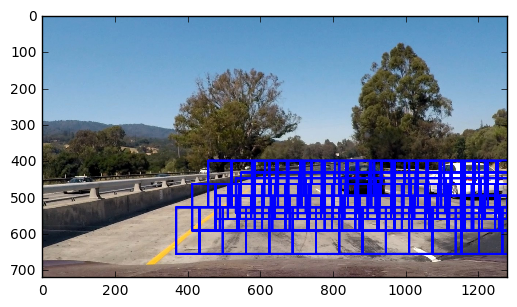

In [ ]:
# 3 Different window sizes
windowx = windowy = 128
windowx2 = windowy2 = 96
windowx3 = windowy3 = 64
# Start and stop positions for different window sizes
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
x_start_stop = [280,None]
y_start_stop2 = [400,624]
x_start_stop2 = [400,None]
y_start_stop3 = [400,560]
x_start_stop3 = [410,None]

# Points for incrementing x value of windows
xpointl = 900
xpointr = 1030
xpointl2 = 1150
x_point_r2 = 1030
xpointl3 = 1300
x_point_r3 = 1030



#windows = get_windows(image, windowx, windowy, x_point_l, x_point_r, x_start_stop, 
#                    y_start_stop, num_sizes, dec_per)
windows = slide_window(image, xpointl = xpointl, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(windowx, windowy), xy_overlap=(0.5, 0.5))
windows2 = slide_window(image, xpointl = xpointl2, x_start_stop=x_start_stop2, y_start_stop=y_start_stop2, 
                    xy_window=(windowx2, windowy2), xy_overlap=(0.5, 0.5))
windows3 = slide_window(image, xpointl = xpointl3, x_start_stop=x_start_stop3, y_start_stop=y_start_stop3, 
                    xy_window=(windowx3, windowy3), xy_overlap=(0.5, 0.5))

for i in range(len(windows2)):
    windows.append((windows2[i]))
for i in range(len(windows3)):
    windows.append((windows3[i]))
    
image_loc = 'test_images/test' + str(1) + '.jpg'
image = mpimg.imread(image_loc)
draw_img = draw_boxes(image, windows)
plt.figure(1)
plt.imshow(draw_img)
print('number of windows = ', len(windows))



In [ ]:
def pipeline(img):
    draw_image = np.copy(img)
    image = img.astype(np.float32)/255
    boxes.current_boxes = search_windows(image, windows, y_start_stop2, x_start_stop, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    boxes.current_heat = add_heat(heat, threshold = .5, num_past = 5)
    heatmap = np.clip(boxes.current_heat, 0, 255)
    labels = label(heatmap)
    # draw the detected boxes. Threshold the number of past detections
    draw_img = draw_labeled_bboxes(draw_image, labels, threshold = 2)
    return draw_img
    
    #Uncomment these for testing
    #draw_img = draw_boxes(draw_image, boxes.current_boxes)
    #return draw_img, heatmap


"""test_images = glob.glob('Problems\*.jpeg')
count = 0
for test_image in test_images:
    count +=1
    if count >30 and count <50:
        image = mpimg.imread(test_image)
        image = image.astype(np.float32)/255
        output, heatmap = pipeline(image)
        fig = plt.figure(count)
        plt.subplot(121)
        plt.imshow(output)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
"""

yellow_output = 'test.mp4'
clip2 = VideoFileClip('project_video.mp4')#.subclip(25,30)
yellow_clip = clip2.fl_image(pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

print('Number of false positives: ', boxes.false_positives)
print('Number of detected boxes: ', boxes.num_detected)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


  5%|███▉                                                                            | 63/1261 [00:29<08:34,  2.33it/s]  0%|                                                                                 | 1/1261 [00:00<08:49,  2.38it/s]